# 2D (x-t) field generation and lagrangian simulation

This example will cover:

 - Generation of a synthetic x-t field
 - Advection of sample drifters
 
 
Prerequisite, have parcels installed, see [OceanParcels doc](https://oceanparcels.org).
If under conda environment: `conda install -c conda-forge parcels`


In [1]:
from gptide import cov
from gptide import GPtideScipy

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

#import corner
#import arviz as az

from scipy import stats
from gptide import stats as gpstats

## Generate some data

In [2]:
####
# These are our kernel input parameters
np.random.seed(1)
noise = 0.5
#η = 10 
η = 1. 
ℓ_x = 10e3 # meters
ℓ_t = 86400*5 # seconds

dx = 1000.
dt = 3600.

def kernel_2d(x, xpr, params):
    """
    2D kernel
    
    Inputs:
        x: matrices input points [N,3]
        xpr: matrices output points [M,3]
        params: tuple length 3
            eta: standard deviation
            lx: x length scale
            ly: y length scale
            
    """
    eta, lx, ly = params
    
    # Build the covariance matrix
    C  = cov.matern32(x[:,1,None], xpr.T[:,1,None].T, ly) 
    C *= cov.matern32(x[:,0,None], xpr.T[:,0,None].T, lx)
    C *= eta**2 
    
    return C

covfunc = kernel_2d

###
# Domain size parameters
Nx = 100
#Nt = 30
Nt = 24*2 # can't do more !!

covparams = (η, ℓ_x, ℓ_t)

# Input data points
xd = np.arange(0,dx*Nx,dx)[:,None]-dx/2
td = np.arange(0,dt*Nt,dt)[:,None]-dt/2

# Make a grid
Xg, Tg = np.meshgrid(xd, td)

# Vectorise grid and stack
Xv = Xg.ravel()
Tv = Tg.ravel()
X = np.hstack([Xv[:,None], Tv[:,None]])

GP = GPtideScipy(X, X.copy(), noise, covfunc, covparams)

In [3]:
# Use the .prior() method to obtain some samples
zd = GP.prior(samples=1)
zg = zd.reshape(Xg.shape)

In [4]:
Xg.shape

(48, 100)

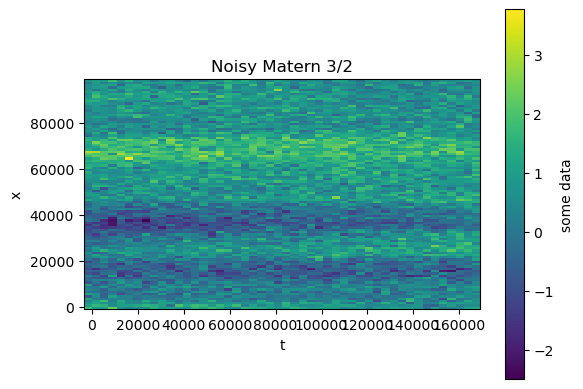

In [5]:
plt.figure()
#plt.scatter(Xg, Tg, c=zg)
plt.pcolormesh(Tg, Xg, zg)
plt.ylabel('x')
plt.xlabel('t')
plt.title('Noisy Matern 3/2')
plt.colorbar(label='some data')
plt.gca().set_aspect('equal')

## setup parcels

In [6]:
from datetime import timedelta

import xarray as xr

from parcels import (
    AdvectionRK4,
    FieldSet,
    JITParticle,
    ParticleSet,
    Variable,
    plotTrajectoriesFile,
)

In [7]:
ds = xr.Dataset(dict(U=(("time", "lon"), zg)), 
                coords=dict(lon=("lon", xd.squeeze()),
                            lat=("lat", np.arange(-1,2)),
                            time=("time", td.squeeze()),
                           ),
               )
ds["U"] = ds["U"] + ds.lat*0.
ds["V"] = ds["U"]*0.

buffer = (dx*2, float(xd[-1])-2*dx)
ds["U"] = ds["U"].where( (ds["lon"]>buffer[0]) & (ds["lon"]<buffer[1]) )
ds["V"] = ds["V"].where( (ds["lon"]>buffer[0]) & (ds["lon"]<buffer[1]) )

ds["time"].attrs["units"] = "seconds"
ds = ds.transpose("time", "lat", "lon")

In [8]:
fieldset = FieldSet.from_xarray_dataset(
    ds,
    variables=dict(U="U", V="V"),
    dimensions=dict(lon="lon", lat="lat", time="time"),                         
    mesh="flat",
)

In [9]:
x0 = xd[1:-1].squeeze()
y0 = x0*0
#t0 = x0*0. + td[1]

In [10]:
pset = ParticleSet.from_list(
    fieldset=fieldset,  # the fields on which the particles are advected
    pclass=JITParticle,  # the type of particles (JITParticle or ScipyParticle)
    lon=x0,  # a vector of release longitudes
    lat=y0,  # a vector of release latitudes
    #time=t0,
)

In [11]:
print(pset)

P[0](lon=500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[1](lon=1500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[2](lon=2500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[3](lon=3500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[4](lon=4500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[5](lon=5500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[6](lon=6500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[7](lon=7500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[8](lon=8500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[9](lon=9500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[10](lon=10500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[11](lon=11500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[12](lon=12500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[13](lon=13500.000000, lat=0.000000, depth=0.000000, time=not_yet_set)
P[14](lon=145

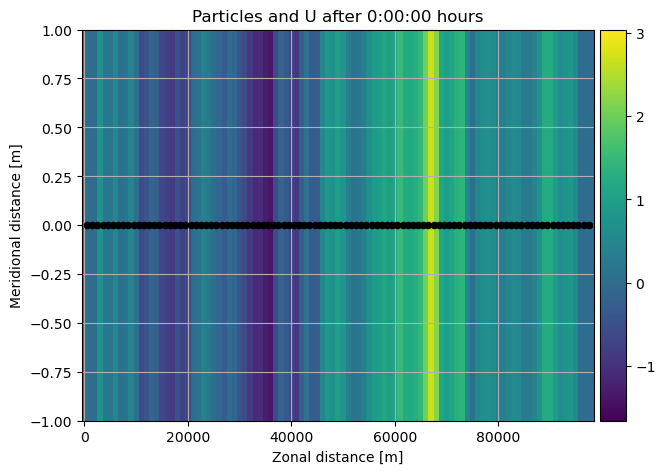

In [12]:
pset.show(field=fieldset.U)

In [13]:
zarr = "EddyParticles.zarr"

In [14]:
output_file = pset.ParticleFile(
    name=zarr,  # the file name
    outputdt=timedelta(hours=1),  # the time step of the outputs
)
pset.execute(
    AdvectionRK4,  # the kernel (which defines how particles move)
    runtime=timedelta(days=1),  # the total length of the run
    dt=timedelta(minutes=30),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Compiled ArrayJITParticleAdvectionRK4 ==> /var/folders/pb/vp119fcj1pn3dc3x2dz4dkt80000gn/T/parcels-501/lib663b9027cfe4a7b21498ffcf1d5841af_0.so


In [15]:
ds = xr.open_zarr("EddyParticles.zarr")

In [16]:
ds = ds.assign_coords(t=(ds["time"] - ds["time"][0,0])/pd.Timedelta("1D"))

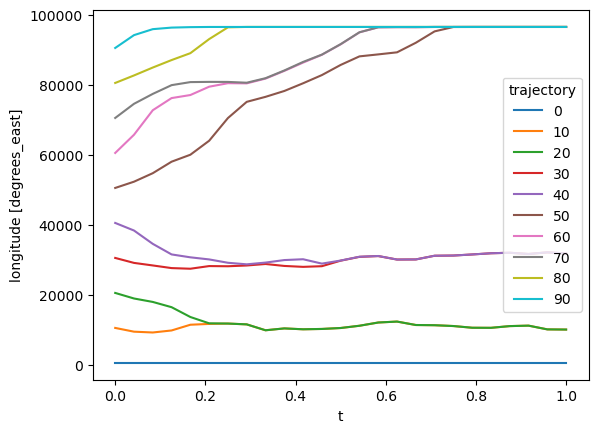

In [17]:
fig, ax = plt.subplots(1, 1)
#ax.scatter(ds["t"], ds["lon"], s=1)
ds["lon"].isel(trajectory=slice(0,None,10)).plot(x="t", hue="trajectory");

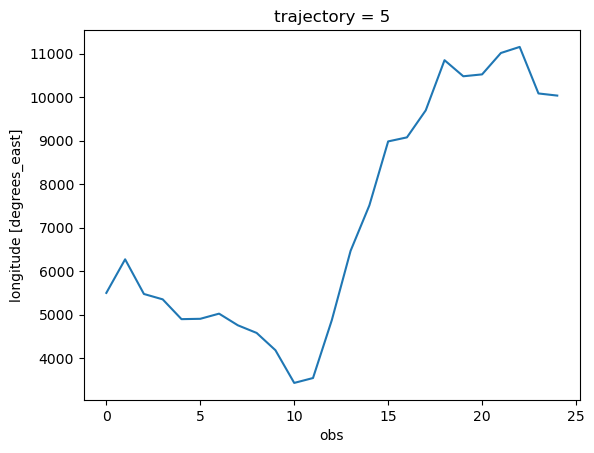

In [18]:
_ds = ds.isel(trajectory=5)
_ds["lon"].plot()